# Classifying adversarial images

In order to aid in the correct classification of traffic signs, we wanted to explore designing a binary classifier which could distinguish between adversarial images and untampered images. In this notebook, the class label 1 represents an adversarial image and the class label 0 represents an untampered image.
As the noisy image attacks were to be dealt with by the denoiser, they are included in this notebook as non-adversary images (label 0).

The idea would be to run images through this classifier first, before inputting the images into the multiclass CNN. The output from this binary classifier would serve as an additional feature for the multiclass CNN and would advise on whether the image it was classifying has been perturbed. 

First, import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Next, define the file paths for the adversarial images and real images. If you would like to replicate this notebook, the adversarial images after being through the autoencoder can be found [here](https://drive.google.com/drive/u/0/folders/1tg24731_oseORhm1v2AMW-mOtC2wW8IJ). The untampered image npy file can be found [here](https://drive.google.com/drive/u/0/folders/1tg24731_oseORhm1v2AMW-mOtC2wW8IJ) and is called 'filter_denoised .npy'. Once downloaded, you can edit the file paths below to match your desktop file paths.

In [2]:
#untampered dataset (with bright dark filter applied), stored as npy files within folders
untampered = np.load('filter_denoised .npy')

#adversarial image dataset, stored as 3 npy files - 3 types of adversarial attacks
adv_data2 = np.load('black_patched_denoised.npy')
adv_data3 = np.load('white_patched_denoised.npy')
adv_data4 = np.load('same_image_patched_denoised.npy')
noisy = np.load('noisy_train_denoised.npy')

Next, we want to create an array which stores the class labels. We shall store 117627 1's to the labels array and append 78418 0's for the number of original images and noisy images. We are giving the noisy images a label of 0 for non-adversary as we assume that having been through the auotencoder, they will have had the noise removed. We then combine the adversary and untampered ndarrays to form one training set, before shuffling both the training set and labels (using the same index).

In [3]:
ones = np.ones(117627,dtype='float32')
zeros = np.zeros(78418,dtype='float32')
labels = np.concatenate((ones,zeros),axis=0)


In [4]:
training_set = np.concatenate((adv_data2,adv_data3,adv_data4,untampered),axis=0,dtype='float32')

In [5]:
s=np.arange(training_set.shape[0])
np.random.seed(42)
np.random.shuffle(s)
training_set=training_set[s]
labels=labels[s]

Here we create the train-validation split.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(training_set, labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train
X_val = X_val

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (109785, 32, 32, 3)
X_valid.shape (47051, 32, 32, 3)
y_train.shape (109785,)
y_valid.shape (47051,)


Next we define the structure of the model.

In [7]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(), #normalises output mean close to 0
    keras.layers.Dropout(rate=0.4),
    
    keras.layers.Dense(1, activation='sigmoid')
    
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0

In [8]:
lr = 0.001
epochs = 1

opt =tf.keras.optimizers.legacy.Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

C:\Users\Team Knowhow\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

3431/3431 [==============================] - 400s 115ms/step - loss: 0.5692 - accuracy: 0.7234 - val_loss: 0.4829 - val_accuracy: 0.7517


Below plots should only be ran if more than one epoch is used.

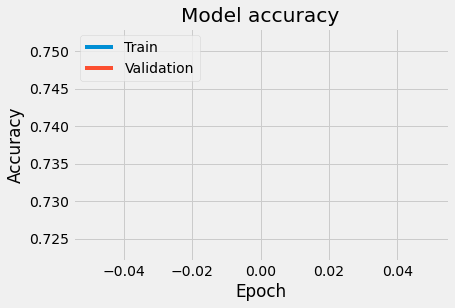

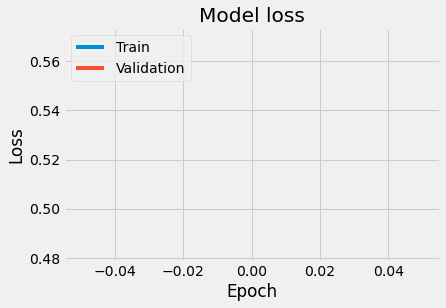

In [10]:
# summarize history for accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()